# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# simulation output folder
experiment_name = 'full_level_runs_4'

# load Java simulation data
experiment_folder = fr'C:\Users\jesse\Documents\EPA_TUDelft\MasterThesis\thesis_experiments\SIMLAB-BOTLEK\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        run_i = 0
        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            if run_i > 1:
                break
            
            run_i += 1

            # open zip file (remove .csv form file name)
            # try:
            with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                # read sequence csv
                with zip_ref.open(file) as data_file:
                    df_run = pd.read_csv(data_file)
                    df_interest = df_run[columns_of_interest].copy()
                    df_interest['run'] = run_number
            # add input values to the dataframe if the input file is specified
            if input_file is not None:
                # open input zip file
                with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                    # read input csv
                    with zip_ref.open(input_file) as input_data_file:
                        df_input = pd.read_csv(input_data_file)
                # broadcast input data to all rows in df_interest
                for col in df_input.columns:
                    df_interest[col] = df_input[col].iloc[0]

            # add this data to the main DataFrame
            df = pd.concat([df, df_interest])
            # except:
            #     print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Analyse progress of simulation variables

Selected variables are chosen and their progress is plotted. It is likely that the values of a variable will approach a stable value. This stabalization will indicate that the simulation has achieved a stable state.

In [5]:
# selected warm-up time
# warm_up_time = None
warm_up_time = 364

In [12]:
def show_fd_data_progress(df, warm_up_time_value):
    # create plots for all variables
    n_columns = 3
    n_rows = (len(df.columns) + 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable/column
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' combination
        run_seed_grouped = df.groupby(['run', 'seed'])
    
        # plot each run-seed combination
        for (run, seed), run_seed_group in run_seed_grouped:
            # plot line
            run_seed_group.reset_index()
            line, = axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed{seed}, run{run}', alpha=0.5)
            line_color = line.get_color()
    
        # plot selected warm-up time
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', label='Warm-up time')
            
        # set plot titles and labels
        units = '-'
        if 'speed' in column:
            units = 'm/s'
        elif 'flow' in column:
            units = 'vehicle/s'
        elif 'density' in column:
            units = 'vehicle/m'
            
        axes[i].set_title(f'{column.replace("_", " ")} progression over time')
        axes[i].set_xlabel('time [s]')
        axes[i].set_ylabel(f'{column.split("_")[1]} [{units}]')
        axes[i].grid(True)
    
        # extend only the right (x_max) and top (y_max) by 10%
        x_min, x_max = axes[i].get_xlim()
        y_min, y_max = axes[i].get_ylim()
        axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
        
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show plots
    plt.tight_layout()
    plt.show()


def show_fd_data_progress_ma(df, warm_up_time_value, window_size):
    # create plots for all variables
    n_columns = 3
    n_rows = (len(df.columns) + 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable/column
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' combination
        run_seed_grouped = df.groupby(['run', 'seed'])
    
        # plot each run-seed combination with moving average
        for (run, seed), run_seed_group in run_seed_grouped:
            # Sort by time to ensure correct rolling calculation
            run_seed_group = run_seed_group.sort_values(by='time')

            # Calculate moving average for the selected column
            run_seed_group[f'{column}_moving_avg'] = run_seed_group[column].rolling(window=window_size, min_periods=1).mean()
            
            # Plot moving average
            line, = axes[i].plot(run_seed_group['time'], run_seed_group[f'{column}_moving_avg'], 
                                 label=f'Seed {seed}, Run {run} (MA)', alpha=0.7)
    
        # Plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
            
        # Set plot titles and labels
        units = '-'
        if 'speed' in column:
            units = 'm/s'
        elif 'flow' in column:
            units = 'vehicle/s'
        elif 'density' in column:
            units = 'vehicle/m'
            
        axes[i].set_title(f'{column.replace("_", " ")} moving average progression over time')
        axes[i].set_xlabel('time [s]')
        axes[i].set_ylabel(f'{column.split("_")[1]} [{units}]')
        axes[i].grid(True)
    
        # Extend only the right (x_max) and top (y_max) by 10%
        x_min, x_max = axes[i].get_xlim()
        y_min, y_max = axes[i].get_ylim()
        axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
        
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show plots
    plt.tight_layout()
    plt.show()

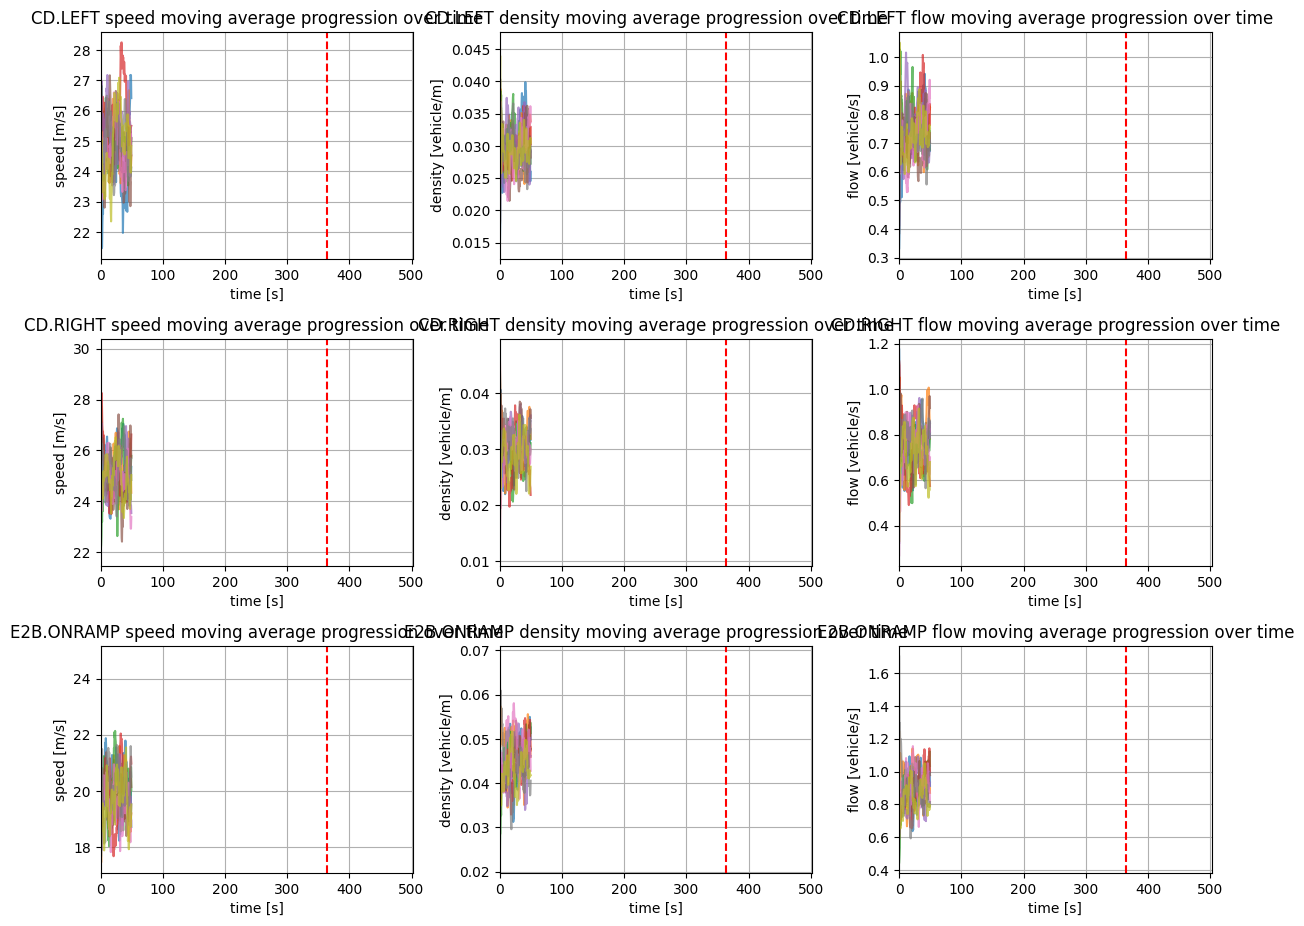

In [15]:
# get intermediate FD values
variables = ['CD.LEFT_speed', 'CD.LEFT_density', 'CD.LEFT_flow',
             'CD.RIGHT_speed', 'CD.RIGHT_density', 'CD.RIGHT_flow',
             'E2B.ONRAMP_speed', 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow']
# df_intermediate = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# df_intermediate['time'] = df_intermediate.groupby(['seed', 'run']).cumcount() * 30
# variables_of_interest = ['time', 'seed', 'run'] + variables
# columns_to_include = [col for col in df_intermediate.columns if col in variables_of_interest]
# df_filtered = df_intermediate[columns_to_include]

seeds = [0, 1, 2]
runs_per_seed = 3
time_steps = 100
data = {
    'time': [],
    'seed': [],
    'run': [],
    'CD.LEFT_speed': [],
    'CD.LEFT_density': [],
    'CD.LEFT_flow': [],
    'CD.RIGHT_speed': [],
    'CD.RIGHT_density': [],
    'CD.RIGHT_flow': [],
    'E2B.ONRAMP_speed': [],
    'E2B.ONRAMP_density': [],
    'E2B.ONRAMP_flow': []
}
for seed in seeds:
    for run in range(runs_per_seed):
        for t in range(time_steps):
            # Basic identifiers
            data['time'].append(t / 2)
            data['seed'].append(seed)
            data['run'].append(run)
            
            # Synthetic values for speed, density, and flow for each lane
            data['CD.LEFT_speed'].append(np.random.uniform(20, 30))     # random speed in m/s
            data['CD.LEFT_density'].append(np.random.uniform(0.01, 0.05))  # density in veh/m
            data['CD.LEFT_flow'].append(data['CD.LEFT_speed'][-1] * data['CD.LEFT_density'][-1])  # flow = speed * density

            data['CD.RIGHT_speed'].append(np.random.uniform(20, 30))
            data['CD.RIGHT_density'].append(np.random.uniform(0.01, 0.05))
            data['CD.RIGHT_flow'].append(data['CD.RIGHT_speed'][-1] * data['CD.RIGHT_density'][-1])

            data['E2B.ONRAMP_speed'].append(np.random.uniform(15, 25))
            data['E2B.ONRAMP_density'].append(np.random.uniform(0.02, 0.07))
            data['E2B.ONRAMP_flow'].append(data['E2B.ONRAMP_speed'][-1] * data['E2B.ONRAMP_density'][-1])

# Create the DataFrame
df_filtered = pd.DataFrame(data)

show_fd_data_progress_ma(df_filtered, warm_up_time, 10)


In [23]:
def show_gtu_data_progress(df, warm_up_time_value):
    # Sort the data by seed and run to ensure consistent ordering
    df = df.sort_values(by=['seed', 'run', 'time'])

    # Create plots for all variables of interest
    n_columns = 3
    n_rows = len(df.columns.drop(['time', 'seed', 'run']))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable of interest (excluding 'time', 'seed', 'run')
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' and calculate the mean for each time step within each group
        run_seed_grouped = df.groupby(['run', 'seed', 'time']).agg({column: 'mean'}).reset_index()
    
        # Plot the mean progression for each (run, seed) combination
        for (run, seed), run_seed_group in run_seed_grouped.groupby(['run', 'seed']):
            # Plot the mean value for each time step
            axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed {seed}, Run {run}', alpha=0.5)
    
        # Plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
    
        # Set plot titles, labels, and other formatting
        units = 'm/s' if 'speed' in column else 'm/s²' if 'acceleration' in column else 's'
        axes[i].set_title(f'Mean {column.replace("_", " ")} progression over time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column} [{units}]')
        axes[i].grid(True)
    
    # Hide any unused subplots if fewer variables than subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show the plots with a tight layout
    plt.tight_layout()
    plt.show()

# because of many fluctuations, a moving average is applied to see the underlying trend
def show_gtu_data_progress_ma(df, warm_up_time_value, window_size=5):
    # Sort the data by seed, run, and time to ensure consistent ordering
    df = df.sort_values(by=['seed', 'run', 'time'])

    # Create plots for all variables of interest
    n_columns = 3
    n_rows = len(df.columns.drop(['time', 'seed', 'run']))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable of interest (excluding 'time', 'seed', 'run')
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run', 'seed' and 'time' and calculate the mean for each time step within each group
        run_seed_grouped = df.groupby(['run', 'seed', 'time']).agg({column: 'mean'}).reset_index()
    
        # Plot the moving average progression for each (run, seed) combination
        for (run, seed), run_seed_group in run_seed_grouped.groupby(['run', 'seed']):
            # Sort by time for rolling calculation
            run_seed_group = run_seed_group.sort_values(by='time')

            # Calculate moving average for the selected column
            run_seed_group[f'{column}_moving_avg'] = run_seed_group[column].rolling(window=window_size, min_periods=1).mean()
            
            # Plot the moving average progression over time
            axes[i].plot(run_seed_group['time'], run_seed_group[f'{column}_moving_avg'], label=f'Seed {seed}, Run {run} (MA)', alpha=0.7)
    
        # Plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
    
        # Set plot titles, labels, and other formatting
        units = 'm/s' if 'speed' in column else 'm/s²' if 'acceleration' in column else 's'
        axes[i].set_title(f'Moving Average of {column.replace("_", " ")} Progression Over Time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column} [{units}]')
        axes[i].grid(True)
    
    # Hide any unused subplots if fewer variables than subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show the plots with a tight layout
    plt.tight_layout()
    plt.show()

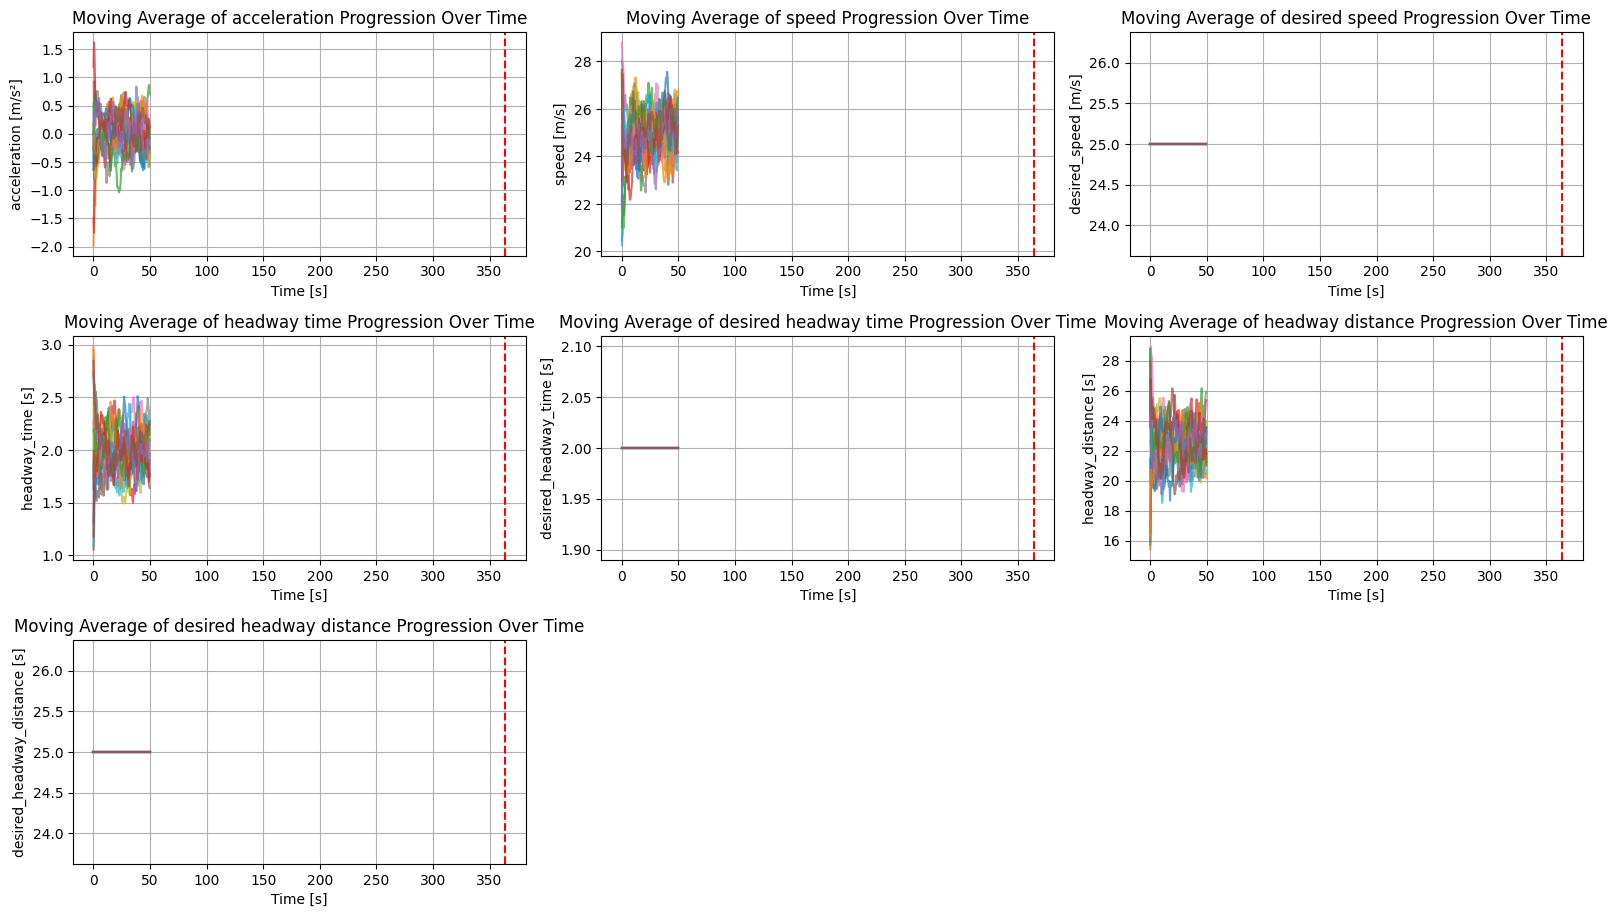

In [24]:
# Define variables and load data
variables = ['time', 'acceleration', 'speed', 'desired_speed', 'headway_time', 'desired_headway_time', 'headway_distance']
# df_sequence = load_dataframe(variables, experiment_folder, sequence_output, input_values)
# variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
# columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
# df_filtered = df_sequence[columns_to_include]

seeds = [0, 1, 2, 3]
runs_per_seed = 4
time_steps = 100
data = {
    'time': [],
    'seed': [],
    'run': [],
    'acceleration': [],
    'speed': [],
    'desired_speed': [],
    'headway_time': [],
    'desired_headway_time': [],
    'headway_distance': [],
    'desired_headway_distance': []
}
for seed in seeds:
    for run in range(runs_per_seed):
        for t in range(time_steps):
            # Add basic identifiers
            data['time'].append(t / 2)
            data['seed'].append(seed)
            data['run'].append(run)
            
            # Generate synthetic values for each variable of interest
            data['acceleration'].append(np.random.normal(0, 1))  # random acceleration
            data['speed'].append(np.random.uniform(20, 30))      # random speed in m/s
            data['desired_speed'].append(25)                     # target speed
            data['headway_time'].append(np.random.uniform(1, 3)) # headway time in seconds
            data['desired_headway_time'].append(2.0)             # target headway time
            data['headway_distance'].append(np.random.uniform(15, 30)) # headway distance in meters
            data['desired_headway_distance'].append(25.0)        # target headway distance

# Create DataFrame from data
df_filtered = pd.DataFrame(data)

show_gtu_data_progress_ma(df_filtered, warm_up_time, 10)

In [10]:
# # window size for sliding window significance test
# window_size = 115
# print(f'Window size: {window_size}\n')

# # only include mean variables (and seed and run numbers)
# variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
# columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
# df_filtered = df_sequence[columns_to_include]

# # dictionary to store warm-up times per variable
# warm_up_time_dict = {}

# # loop through each variable/column
# for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
#     # add column to dictionary with corresponding list
#     warm_up_time_dict[column] = []
    
#     # group by run and seed combination
#     run_seed_grouped = df_filtered.groupby(['run', 'seed'])

#     # loop through each run-seed combination
#     for (run, seed), run_seed_group in run_seed_grouped:
#         # calculate mean per time step
#         df_mean_by_time = df_sequence.groupby('time').agg({column: 'mean',}).reset_index()
#         df_mean_by_time.set_index('time', inplace=True)

#         # determine warm-up time
#         for t in range(window_size, len(df_mean_by_time)):
#             # compare the distribution of the variable before and after time `t`
#             pre_warmup = df_mean_by_time[column][t-window_size:t]
#             post_warmup = df_mean_by_time[column][t:t+window_size]
    
#             # ensure non-zero sizes for both slices
#             if len(pre_warmup) > 0 and len(post_warmup) > 0:
#                 # perform Mann-Whitney U Test
#                 stat, p_value = mannwhitneyu(pre_warmup, post_warmup)
    
#                 # determine if the null hypothesis is rejected (p-value > 0.05)
#                 if p_value > 0.05:
#                     warm_up_time = t
#                     warm_up_time_dict[column].append(warm_up_time)
                    
#                     # break after finding the warm-up time for this column
#                     break

# # show the warm-up times per variable
# for variable in warm_up_time_dict.keys():
#     warm_up_time_dict[variable].sort()
#     print(f'{variable}: warm-up times = {warm_up_time_dict[variable]}')

### 3. Conclusions
Graphs of variable progress through simulation runs already showed that a warm-up time is required. In the first x seconds of the simulation, vehicles are filling up the freeway network and variables have a high variability during this period. While this variability remains high for the fundamental diagram variables (mean speed, mean flow and mean density), the individual GTU variables (acceleration, speed, desired headway etc.) do show stabilization after a while. A statistical significance test is performed on these variables to determine the duration of the warm-up time required to reach the stable state of the simulation. The result is a warm-up time of <b>364</b> seconds.

When this warm-up time is plotted into the variable progress graphs, the visuals clearly show that the post-warm-up duration of the simulation shows less variability than in the pre-warm-up duration.